In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc

import pandas as pd
import numpy as np
import itertools

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
data = pd.read_csv('../data/SMSSpamCollection', sep='\t', header=None)
data['Text'] = data[1].str.replace('[^\w\s]','')
data.columns = ['label', 'Full Text', 'Text']
data['Lower Case Text'] = data['Text'].str.lower()

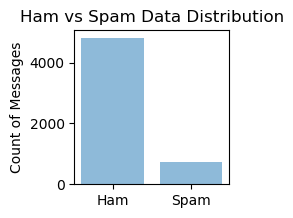

In [4]:
#log loss for train set and validation set
#accuracy with different vocabulary size and embedding size.Although the accuracy can grows up as the dimension and vocabularysize grows, the consuming time also grows up dramatically. Howeverthe accuracy grows a little bit.

#exploritory charts:

data.groupby('label').count()

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Ham', 'Spam')
y_pos = np.arange(len(objects))
performance = [4825, 747]
#0.865936827%, 0.134063173% split

plt.rcParams['figure.figsize'] = 2, 2
ax = plt.subplot(111)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count of Messages')
plt.title('Ham vs Spam Data Distribution')
plt.show()

In [9]:
spam_wordcount = data.loc[data['label'] == "spam"]
spam_wordcount['Count of Words'] = spam_wordcount['Text'].str.split().str.len()
spam_std = np.std(spam_wordcount['Count of Words'])
spam_mean = np.mean(spam_wordcount['Count of Words'])

ham_wordcount = data.loc[data['label'] == "ham"]
ham_wordcount['Count of Words'] = ham_wordcount['Text'].str.split().str.len()
ham_std = np.std(ham_wordcount['Count of Words'])
ham_mean = np.mean(ham_wordcount['Count of Words'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


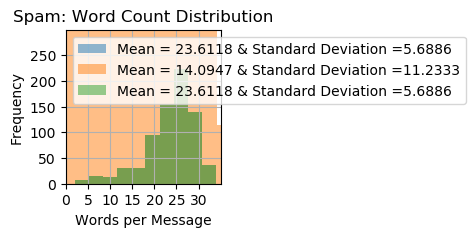

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 2, 2
ax = plt.subplot(111)
plt.hist(spam_wordcount['Count of Words'], alpha=0.5, label= 'Mean = ' + str(round(spam_mean, 4)) + ' & Standard Deviation =' + str(round(spam_std, 4)))
plt.xlabel('Words per Message')
plt.xticks(np.arange(0, 35, step=5))
plt.xlim([0.0, 35.0])
plt.ylabel('Frequency')
plt.yticks(np.arange(0, 300, step=50))
plt.ylim([0.0, 300.0])
plt.title('Spam: Word Count Distribution')
plt.grid(True)
leg = plt.legend(loc = 2)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


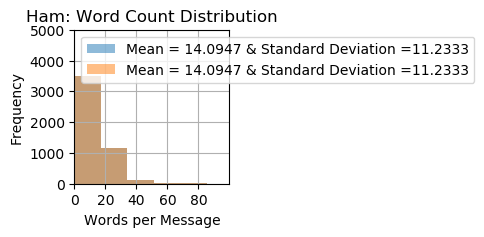

In [11]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 2, 2
ax = plt.subplot(111)
plt.hist(ham_wordcount['Count of Words'], alpha=0.5, label= 'Mean = ' + str(round(ham_mean, 4)) + ' & Standard Deviation =' + str(round(ham_std, 4)))
plt.xlabel('Words per Message')
plt.xticks(np.arange(0, 100, step=20))
plt.xlim([0.0, 100.0])
plt.ylabel('Frequency')
plt.ylim([0.0, 5000.0])
plt.title('Ham: Word Count Distribution')
plt.grid(True)
leg = plt.legend(loc = 2)
plt.show()

In [12]:
#up sample data train for word2vec vocabulary

np.random.seed(42)

labels, counts = np.unique(data['label'], return_counts=True)
encoder = preprocessing.LabelEncoder()
encoder.fit(labels[np.argsort(-counts)])
data['y'] = encoder.transform(data['label'])

mask_train = np.random.random(data.shape[0]) < 0.8
data_train = data[mask_train]
data_test = data.iloc[~mask_train, :]

countToIncrease_word = data_train[data_train['y'] == 0].shape[0] - data_train[data_train['y'] == 1].shape[0]
spamupsampled_word = data_train[data_train['y'] == 1].sample(n=countToIncrease_word, replace=True)
data_train_upsample_word2vec = pd.concat([spamupsampled_word, data_train])

count_vect_sing_word = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
count_vect_sing_word.fit(data_train_upsample_word2vec['Lower Case Text'])
tokenizer_word = count_vect_sing_word.build_tokenizer()

VOCAB_SIZE = len(count_vect_sing_word.vocabulary_)
EMBEDDING_SIZE = 300
word_to_ix = count_vect_sing_word.vocabulary_

class TwoGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(TwoGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

    
CONTEXT_SIZE = 1
EMBEDDING_DIM = EMBEDDING_SIZE

word2vec_model = TwoGramLanguageModeler(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE)

MODEL_PATH = '/Users/allysalib/DataScienceCourse/ipython/data/word_2vec_model'
word_embeddings = word2vec_model.embeddings
word2vec_model.load_state_dict(torch.load(MODEL_PATH))
word2vec_model.eval()

# count_vect_sing_word is a CountVectorizer
def _indicesForSentence(input_str, tokenizer = tokenizer_word, count_vect = count_vect_sing_word):
    input_str = list(filter(lambda x: x in count_vect.vocabulary_, tokenizer(input_str)))
    return torch.tensor([[word_to_ix[word]] for word in input_str], dtype=torch.long)

def getEmbedding(word_index_tensor, embedder):
    embedder(word_index_tensor)
def sentenceToNumpyInstance(input_str, embedder):
    embeddings = embedder(_indicesForSentence(input_str))
    if embeddings.shape == torch.Size([0]):
        return np.zeros(EMBEDDING_SIZE)
    else:
        x = torch.sum(embeddings, dim = 0)
        return torch.Tensor.numpy(x.detach())[0]
    
def word2vec_transform(data, embeddings, field = 'Lower Case Text'):
    return np.array(data[field].apply(sentenceToNumpyInstance, embedder=embeddings).values.tolist())



In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

#label_name =  y 
#pass in transformed data

def crossval(dataset, model_func, parametersModel, embeddings = word_embeddings, vectorizer = None, 
             label_name = 'y', text_field = 'Lower Case Text', k_folds = 5): 
    aucs = {}
    folds = list(KFold(n_splits=k_folds).split(dataset))
    for fold in range(k_folds):
        cv_train = dataset.iloc[folds[fold][0]]
        cv_validate = dataset.iloc[folds[fold][1]]
    
        countToIncrease = cv_train[cv_train['y'] == 0].shape[0] - cv_train[cv_train['y'] == 1].shape[0]
        spamupsampled = cv_train[cv_train['y'] == 1].sample(n=countToIncrease, replace=True)
        cv_train = pd.concat([spamupsampled, cv_train])
        
        if vectorizer is not None:
            cv_train_features = vectorizer.fit_transform(cv_train[text_field])
            cv_train_y = cv_train[label_name]
            cv_validate_features = vectorizer.transform(cv_validate[text_field])
            cv_validate_y = cv_validate[label_name]
        else:
            # LOAD word to vec
            cv_train_features = word2vec_transform(cv_train, embeddings)
            cv_train_y = cv_train[label_name]
            cv_validate_features = word2vec_transform(cv_validate, embeddings)
            cv_validate_y = cv_validate[label_name]
        
        keys, values = zip(*parametersModel.items())
                
        for v in itertools.product(*values):    
            experiment = dict(zip(keys, v))
            m = model_func(**experiment)

            m.fit(cv_train_features, cv_train_y)
            y_preds = m.predict_proba(cv_validate_features)[:, 1]
            fpr, tpr, threshold = metrics.roc_curve(cv_validate_y, y_preds)
            auc_val = metrics.auc(fpr, tpr)  
            
            inside_key = ""

            for e in experiment:
                inside_key = inside_key + "_" + e + ':' + str(experiment[e])
            
            if not inside_key in aucs:
                aucs[inside_key] = []
                aucs[inside_key].append(auc_val)
            else:
                aucs[inside_key].append(auc_val)
    return aucs

In [14]:
count_vect = CountVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS)
tfidf_vect = TfidfVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS)
bigram_count_vect = CountVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS, ngram_range = (2,2))
bigram_tfidf_vect = TfidfVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS, ngram_range = (2,2))
ngram_count_vect = CountVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS, ngram_range = (1,2))
ngram_tfidf_vect = TfidfVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS, ngram_range = (1,2))

In [15]:
RF_parameters = {'n_estimators': [10, 100], 'criterion': ['entropy'], 'max_depth': [None, 1, 3, 7, 10, 50], 'min_samples_split': [2, 10, 50, 100, 250, 500, 750, 1000], 'min_samples_leaf': [1, 10, 25, 50, 75, 100, 125, 150]} 



In [16]:
aucs_count_default = crossval(data_train, RandomForestClassifier, RF_parameters, vectorizer = count_vect)

In [54]:
aucs_tfidf_default = crossval(data_train, RandomForestClassifier, RF_parameters, vectorizer = tfidf_vect)

In [56]:
aucs_count_bigram = crossval(data_train, RandomForestClassifier, RF_parameters, vectorizer = bigram_count_vect)

In [58]:
aucs_tfidf_bigram = crossval(data_train, RandomForestClassifier, RF_parameters, vectorizer = bigram_tfidf_vect)

In [60]:
aucs_count_ngram = crossval(data_train, RandomForestClassifier, RF_parameters, vectorizer = ngram_count_vect)

In [62]:
aucs_tfidf_ngram = crossval(data_train, RandomForestClassifier, RF_parameters, vectorizer = ngram_tfidf_vect)

In [83]:
aucs_word_2_vec = crossval(data_train, RandomForestClassifier, RF_parameters, vectorizer = None)

KeyboardInterrupt: 

In [11]:
def processAUCsResults(aucs_dict):
    aucs = {}
    max_auc = -1
    confs = ""
    for e in aucs_dict:
        mean_auc = np.mean(aucs_dict[e])
        aucs['RF'+ e] = mean_auc
        if mean_auc >= max_auc:
            confs = e
            max_auc = mean_auc
    return aucs, confs

In [12]:
print(processAUCsResults(aucs_count_default))

NameError: name 'aucs_count_default' is not defined

In [55]:
print(processAUCsResults(aucs_tfidf_default))

({'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:1': 0.9752655030033305, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:10': 0.9749745853015354, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:25': 0.9585163828910959, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:50': 0.8659378034114796, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:75': 0.783121172737961, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:100': 0.7879800576515799, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:125': 0.7645458412435922, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:150': 0.6348661707450205, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:10_min

In [57]:
print(processAUCsResults(aucs_count_bigram))

({'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:1': 0.9076543149786159, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:10': 0.8413964998885612, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:25': 0.6095917919869495, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:50': 0.5060869565217392, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:75': 0.5, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:100': 0.5, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:125': 0.5, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:150': 0.5, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:10_min_samples_leaf:1': 0.9015259412774854, 'RF_n_estimators:10_c

In [59]:
print(processAUCsResults(aucs_tfidf_bigram))

({'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:1': 0.9121054460283384, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:10': 0.8293549978931019, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:25': 0.5918293519700966, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:50': 0.5017316341829086, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:75': 0.5, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:100': 0.5, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:125': 0.5, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:150': 0.5, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:10_min_samples_leaf:1': 0.9023181341124996, 'RF_n_estimators:10_c

In [61]:
print(processAUCsResults(aucs_count_ngram))

({'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:1': 0.9683680361636899, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:10': 0.9755191748273642, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:25': 0.9393763029943119, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:50': 0.8106317640165986, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:75': 0.7555658263166374, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:100': 0.6210462326109264, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:125': 0.6378209092289981, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:150': 0.6227623327433824, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:10_mi

In [63]:
print(processAUCsResults(aucs_tfidf_ngram))

({'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:1': 0.9631277282671572, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:10': 0.9685379326255944, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:25': 0.9451541740474114, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:50': 0.8226170317197159, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:75': 0.7328062573022851, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:100': 0.6443680756605639, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:125': 0.637898809329519, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:2_min_samples_leaf:150': 0.5764069442683349, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:10_min

In [47]:
print(processAUCsResults(aucs_word_2_vec))

({'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:100_min_samples_leaf:25': 0.9250012604935535, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:100_min_samples_leaf:50': 0.9214736134304214, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:100_min_samples_leaf:100': 0.9172182981706871, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:100_min_samples_leaf:150': 0.9180037835581356, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:100_min_samples_leaf:200': 0.9121225140577914, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:100_min_samples_leaf:250': 0.9021754926097267, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:500_min_samples_leaf:25': 0.9086476009540524, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_samples_split:500_min_samples_leaf:50': 0.9166201875434844, 'RF_n_estimators:10_criterion:entropy_max_depth:None_min_s

In [18]:
# need to upsample the data_train
# fit the vectorizer
# model should be an instantiated model
# returns the TEST AUC on normal rate and upsampled test
def train_test_run(data_train, data_test, model, embeddings = word_embeddings, vectorizer = None, 
                   label_name = 'y', text_field = 'Lower Case Text'):

    countToIncrease = data_train[data_train['y'] == 0].shape[0] - data_train[data_train['y'] == 1].shape[0]
    spamupsampled = data_train[data_train['y'] == 1].sample(n=countToIncrease, replace=True)
    data_train = pd.concat([spamupsampled, data_train])
    
    downsampled_ham = data_test[data_test['y'] == 0].sample(n=data_test[data_test['y'] == 1].shape[0])
    # the name really should be _downsample, but i dont wanna fix code right now
    data_test_upsample = pd.concat([downsampled_ham, data_test[data_test['y'] == 1]])

    if vectorizer is not None:
        data_train_features = vectorizer.fit_transform(data_train[text_field])
        data_train_y = data_train[label_name]
        data_test_features = vectorizer.transform(data_test[text_field])
        data_test_y = data_test[label_name]
        data_test_upsample_features = vectorizer.transform(data_test_upsample[text_field])
        data_test_upsample_y = data_test_upsample[label_name]
    else:
        # LOAD word to vec
        data_train_features = word2vec_transform(data_train, embeddings)
        data_train_y = data_train[label_name]
        data_test_features = word2vec_transform(data_test, embeddings)
        data_test_y = data_test[label_name]
        data_test_upsample_features = word2vec_transform(data_test_upsample, embeddings)
        data_test_upsample_y = data_test_upsample[label_name]
        
    model.fit(data_train_features, data_train_y)
    y_preds = model.predict_proba(data_test_features)[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(data_test_y, y_preds)
    y_preds_upsample = model.predict_proba(data_test_upsample_features)[:, 1]
    fpr_upsample, tpr_upsample, threshold_upsample = metrics.roc_curve(data_test_upsample_y, y_preds_upsample)
    auc_reg = metrics.auc(fpr, tpr)
    auc_upsample = metrics.auc(fpr_upsample, tpr_upsample)
    PRF1 = metrics.precision_recall_fscore_support(data_test_y, model.predict(data_test_features), average='binary')[:3]    
    return 'AUC: {}, AUC upsampled: {}, Precision: {}, Recall: {}, F1: {}'.format(auc_reg, auc_upsample, PRF1[0], PRF1[1], PRF1[2])

In [19]:
#RF_n_estimators:100_criterion:entropy_max_depth:None_min_samples_split:10_min_samples_leaf:1': 0.9875764806272563

train_test_run(data_train, data_test, RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = None, min_samples_split = 10, min_samples_leaf = 1), vectorizer=count_vect)


'AUC: 0.9831299721177706, AUC upsampled: 0.9828349542749311, Precision: 1.0, Recall: 0.8253012048192772, F1: 0.9042904290429044'

In [20]:
#RF_n_estimators:100_criterion:entropy_max_depth:None_min_samples_split:10_min_samples_leaf:1': 0.9877963146655773

train_test_run(data_train, data_test, RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = None, min_samples_split = 10, min_samples_leaf = 1), vectorizer=tfidf_vect)


'AUC: 0.9852754968920266, AUC upsampled: 0.9862098998403251, Precision: 1.0, Recall: 0.8493975903614458, F1: 0.9185667752442997'

In [21]:
#RF_n_estimators:100_criterion:entropy_max_depth:None_min_samples_split:50_min_samples_leaf:1': 0.9311235754617911

train_test_run(data_train, data_test, RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = None, min_samples_split = 50, min_samples_leaf = 1), vectorizer=bigram_count_vect)


'AUC: 0.9266045072007777, AUC upsampled: 0.9276926985048628, Precision: 1.0, Recall: 0.6566265060240963, F1: 0.7927272727272727'

In [22]:
#RF_n_estimators:100_criterion:entropy_max_depth:None_min_samples_split:1000_min_samples_leaf:1': 0.9312960582800921

train_test_run(data_train, data_test, RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = None, min_samples_split = 1000, min_samples_leaf = 1), vectorizer=bigram_tfidf_vect)


'AUC: 0.90319558488732, AUC upsampled: 0.9024531862389316, Precision: 1.0, Recall: 0.6566265060240963, F1: 0.7927272727272727'

In [23]:
#RF_n_estimators:100_criterion:entropy_max_depth:None_min_samples_split:10_min_samples_leaf:1': 0.9863839603360354

train_test_run(data_train, data_test, RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = None, min_samples_split = 10, min_samples_leaf = 1), vectorizer=count_vect)


'AUC: 0.9844089734735119, AUC upsampled: 0.9856655537813905, Precision: 1.0, Recall: 0.8493975903614458, F1: 0.9185667752442997'

In [24]:
#RF_n_estimators:100_criterion:entropy_max_depth:None_min_samples_split:10_min_samples_leaf:1': 0.9863426186116147

train_test_run(data_train, data_test, RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = None, min_samples_split = 10, min_samples_leaf = 1), vectorizer=ngram_count_vect)


'AUC: 0.9800891463944951, AUC upsampled: 0.9818914211061112, Precision: 1.0, Recall: 0.8072289156626506, F1: 0.8933333333333333'

In [25]:
#RF_n_estimators:100_criterion:entropy_max_depth:None_min_samples_split:10_min_samples_leaf:1': 0.9863426186116147

train_test_run(data_train, data_test, RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = None, min_samples_split = 10, min_samples_leaf = 1), vectorizer= ngram_tfidf_vect)


'AUC: 0.9768149029237971, AUC upsampled: 0.9762483669618233, Precision: 1.0, Recall: 0.7710843373493976, F1: 0.870748299319728'

In [77]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

a = ENGLISH_STOP_WORDS

full_data = data['Text'].tolist()
spam_data = spam_wordcount['Text'].tolist()
ham_data = ham_wordcount['Text'].tolist()

cv = CountVectorizer(binary = True, stop_words = a)

full_data_transformed = cv.fit_transform(full_data)
fd = pd.DataFrame(full_data_transformed.toarray(), columns = cv.get_feature_names())

spam_data_transformed = cv.fit_transform(spam_data)
sd = pd.DataFrame(spam_data_transformed.toarray(), columns = cv.get_feature_names())

ham_data_transformed = cv.fit_transform(ham_data)
hd = pd.DataFrame(ham_data_transformed.toarray(), columns = cv.get_feature_names())

print(fd)

      008704050406  0089my  0121  01223585236  01223585334  0125698789  02  \
0                0       0     0            0            0           0   0   
1                0       0     0            0            0           0   0   
2                0       0     0            0            0           0   0   
3                0       0     0            0            0           0   0   
4                0       0     0            0            0           0   0   
5                0       0     0            0            0           0   0   
6                0       0     0            0            0           0   0   
7                0       0     0            0            0           0   0   
8                0       0     0            0            0           0   0   
9                0       0     0            0            0           0   0   
10               0       0     0            0            0           0   0   
11               0       0     0            0            0      

In [47]:
full_dtt_dict = {}
for entry in full_data_transformed:
    for i in range(len(entry.indices)):
        index = entry.indices[i]
        val = entry.data[i]
        if not index in full_dtt_dict:
            full_dtt_dict[index] = val
        else:
            full_dtt_dict[index] = full_dtt_dict[index] + val

In [39]:
spam_dtt_dict = {}
for entry in spam_data_transformed:
    for i in range(len(entry.indices)):
        index = entry.indices[i]
        val = entry.data[i]
        if not index in spam_dtt_dict:
            spam_dtt_dict[index] = val
        else:
            spam_dtt_dict[index] = spam_dtt_dict[index] + val

In [40]:
ham_dtt_dict = {}
for entry in ham_data_transformed:
    for i in range(len(entry.indices)):
        index = entry.indices[i]
        val = entry.data[i]
        if not index in ham_dtt_dict:
            ham_dtt_dict[index] = val
        else:
            ham_dtt_dict[index] = ham_dtt_dict[index] + val

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114],
 <a list of 115 Text xticklabel objects>)

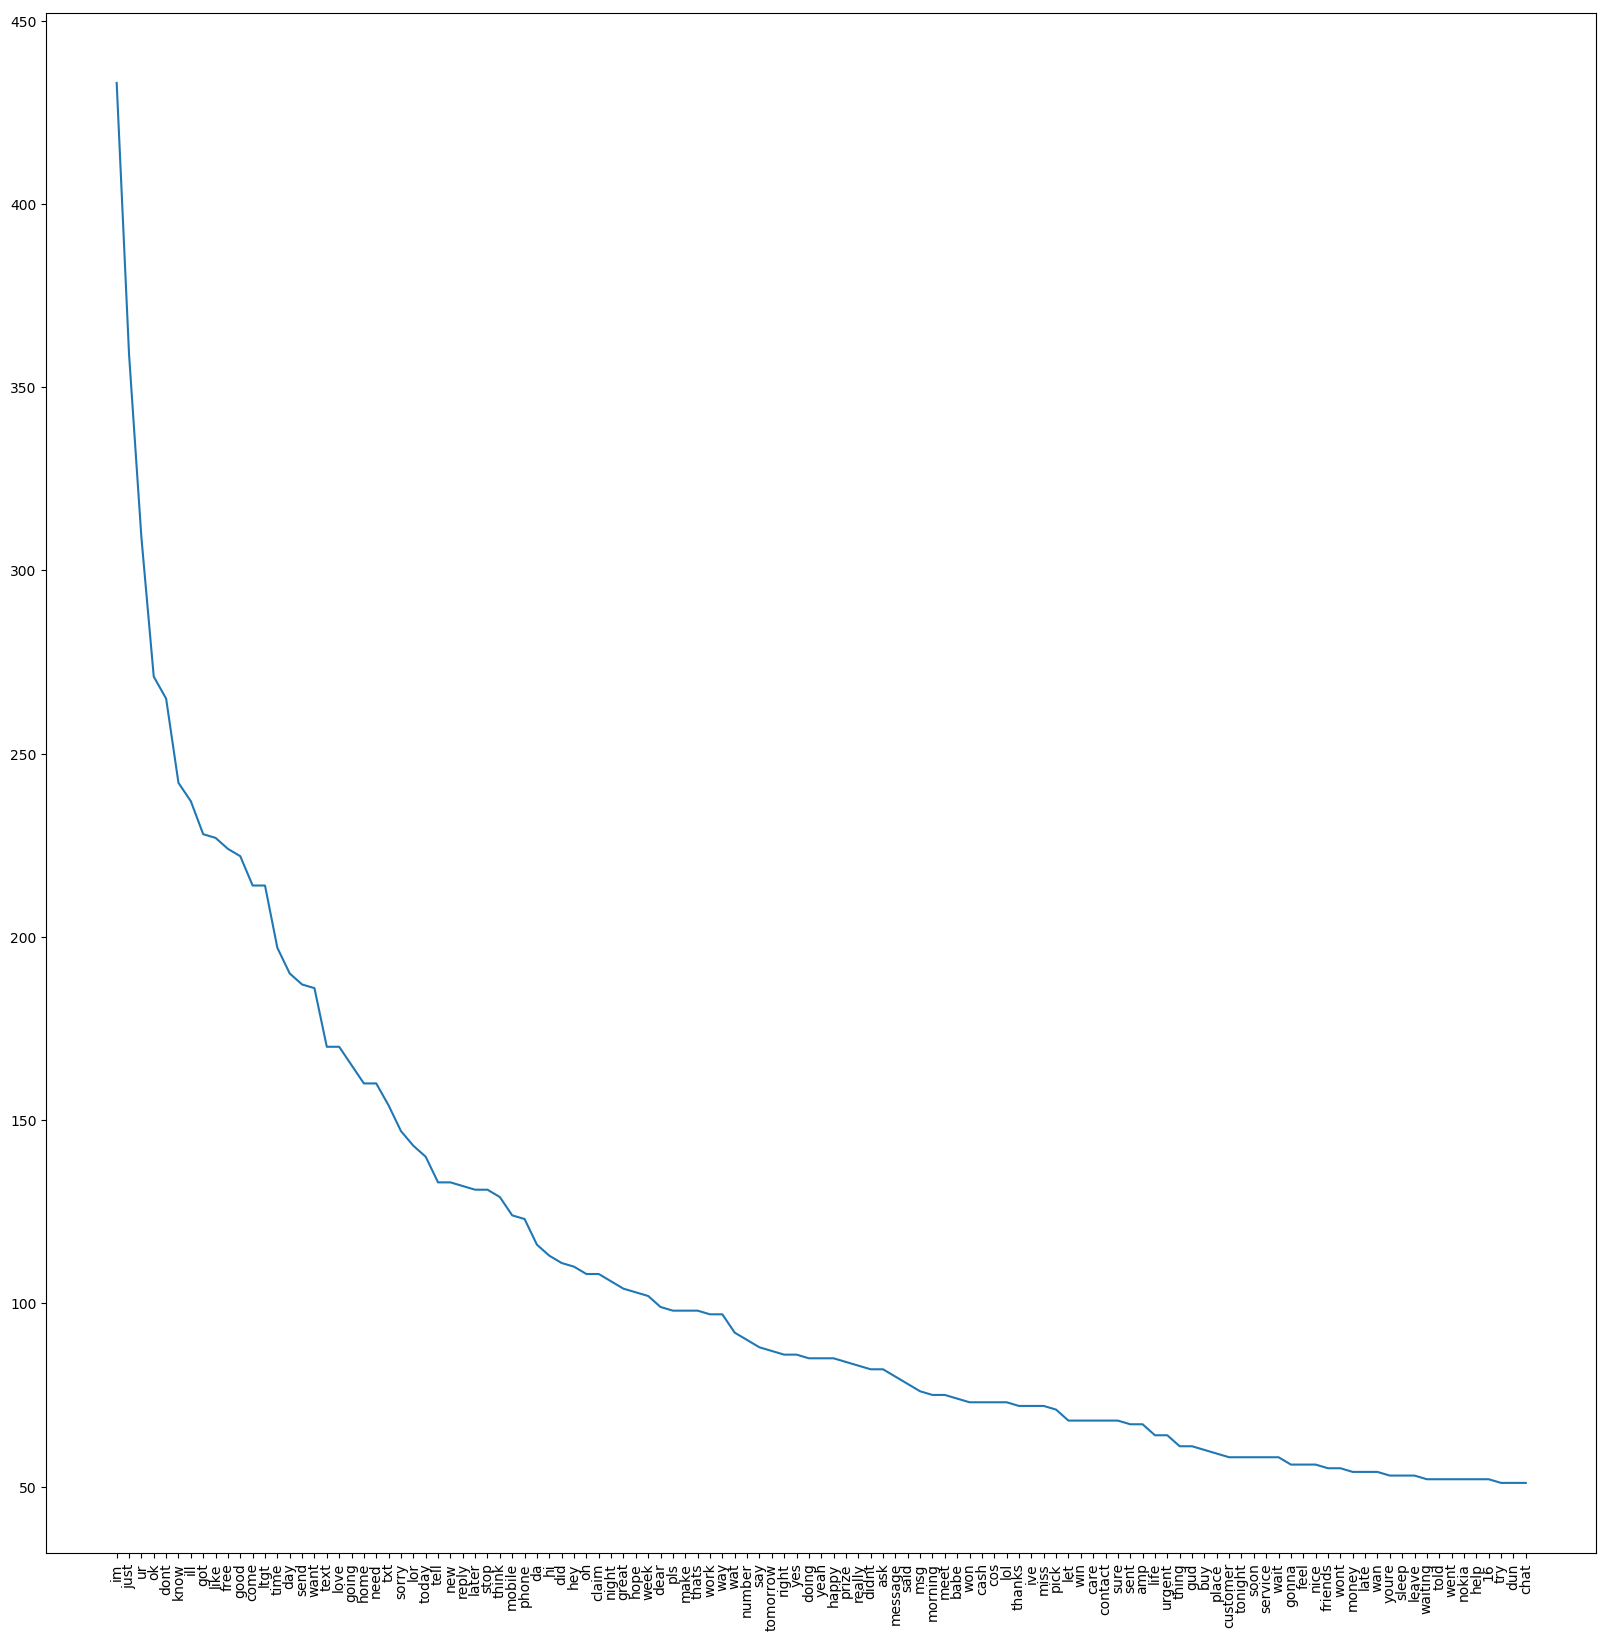

In [76]:
fd_index = pd.RangeIndex(start=0, stop=len(full_dtt_dict))
full_dtt = pd.DataFrame(list(full_dtt_dict.items()), index= fd_index, columns = ['Word', 'Count'])

full_dtt.sort_values(by=['Count'], ascending=False)

full_sums = fd.select_dtypes(pd.np.number).sum().rename('total')
fd1 = fd.append(full_sums)
fd2 = fd1.transpose()
fd3 = pd.DataFrame(fd2)
fd4 = fd3.loc[fd3['total'] > 50]
fd5 = fd4.sort_values(by = 'total', ascending=False)
fd6 = fd5['total']

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 20
plt.plot(fd6.index, fd6)
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56],
 <a list of 57 Text xticklabel objects>)

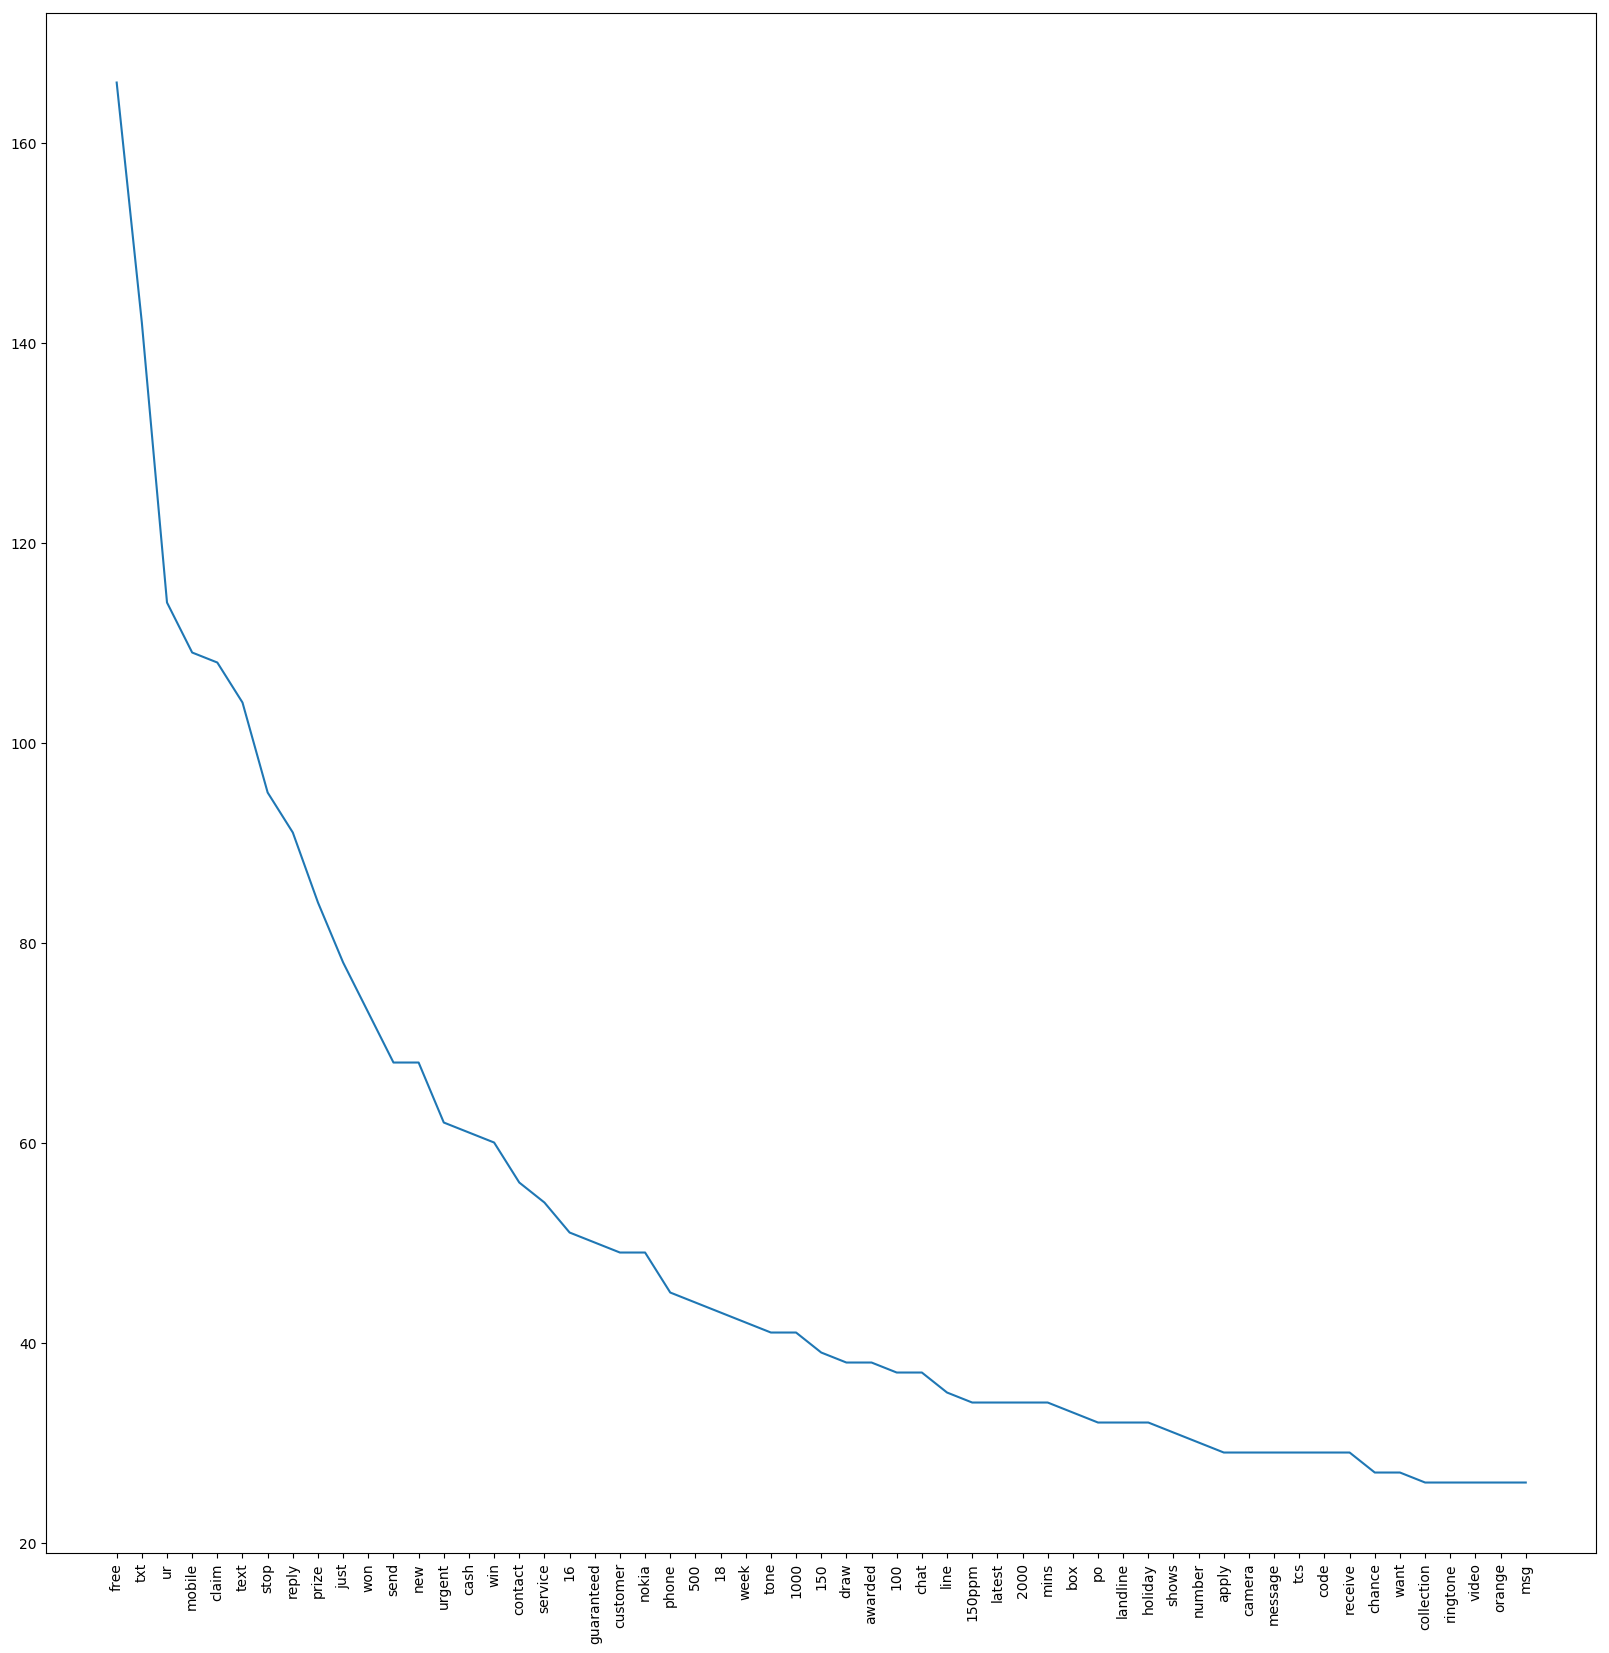

In [75]:
sd_index = pd.RangeIndex(start=0, stop=len(spam_dtt_dict))
spam_dtt = pd.DataFrame(list(spam_dtt_dict.items()), index= sd_index, columns = ['Word', 'Count'])

spam_dtt.sort_values(by=['Count'], ascending=False)

spam_sums = sd.select_dtypes(pd.np.number).sum().rename('total')
sd1 = sd.append(spam_sums)
sd2 = sd1.transpose()
sd3 = pd.DataFrame(sd2)
sd4 = sd3.loc[sd3['total'] > 25]
sd5 = sd4.sort_values(by = 'total', ascending=False)
sd6 = sd5['total']

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 20
plt.plot(sd6.index, sd6)
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text xticklabel objects>)

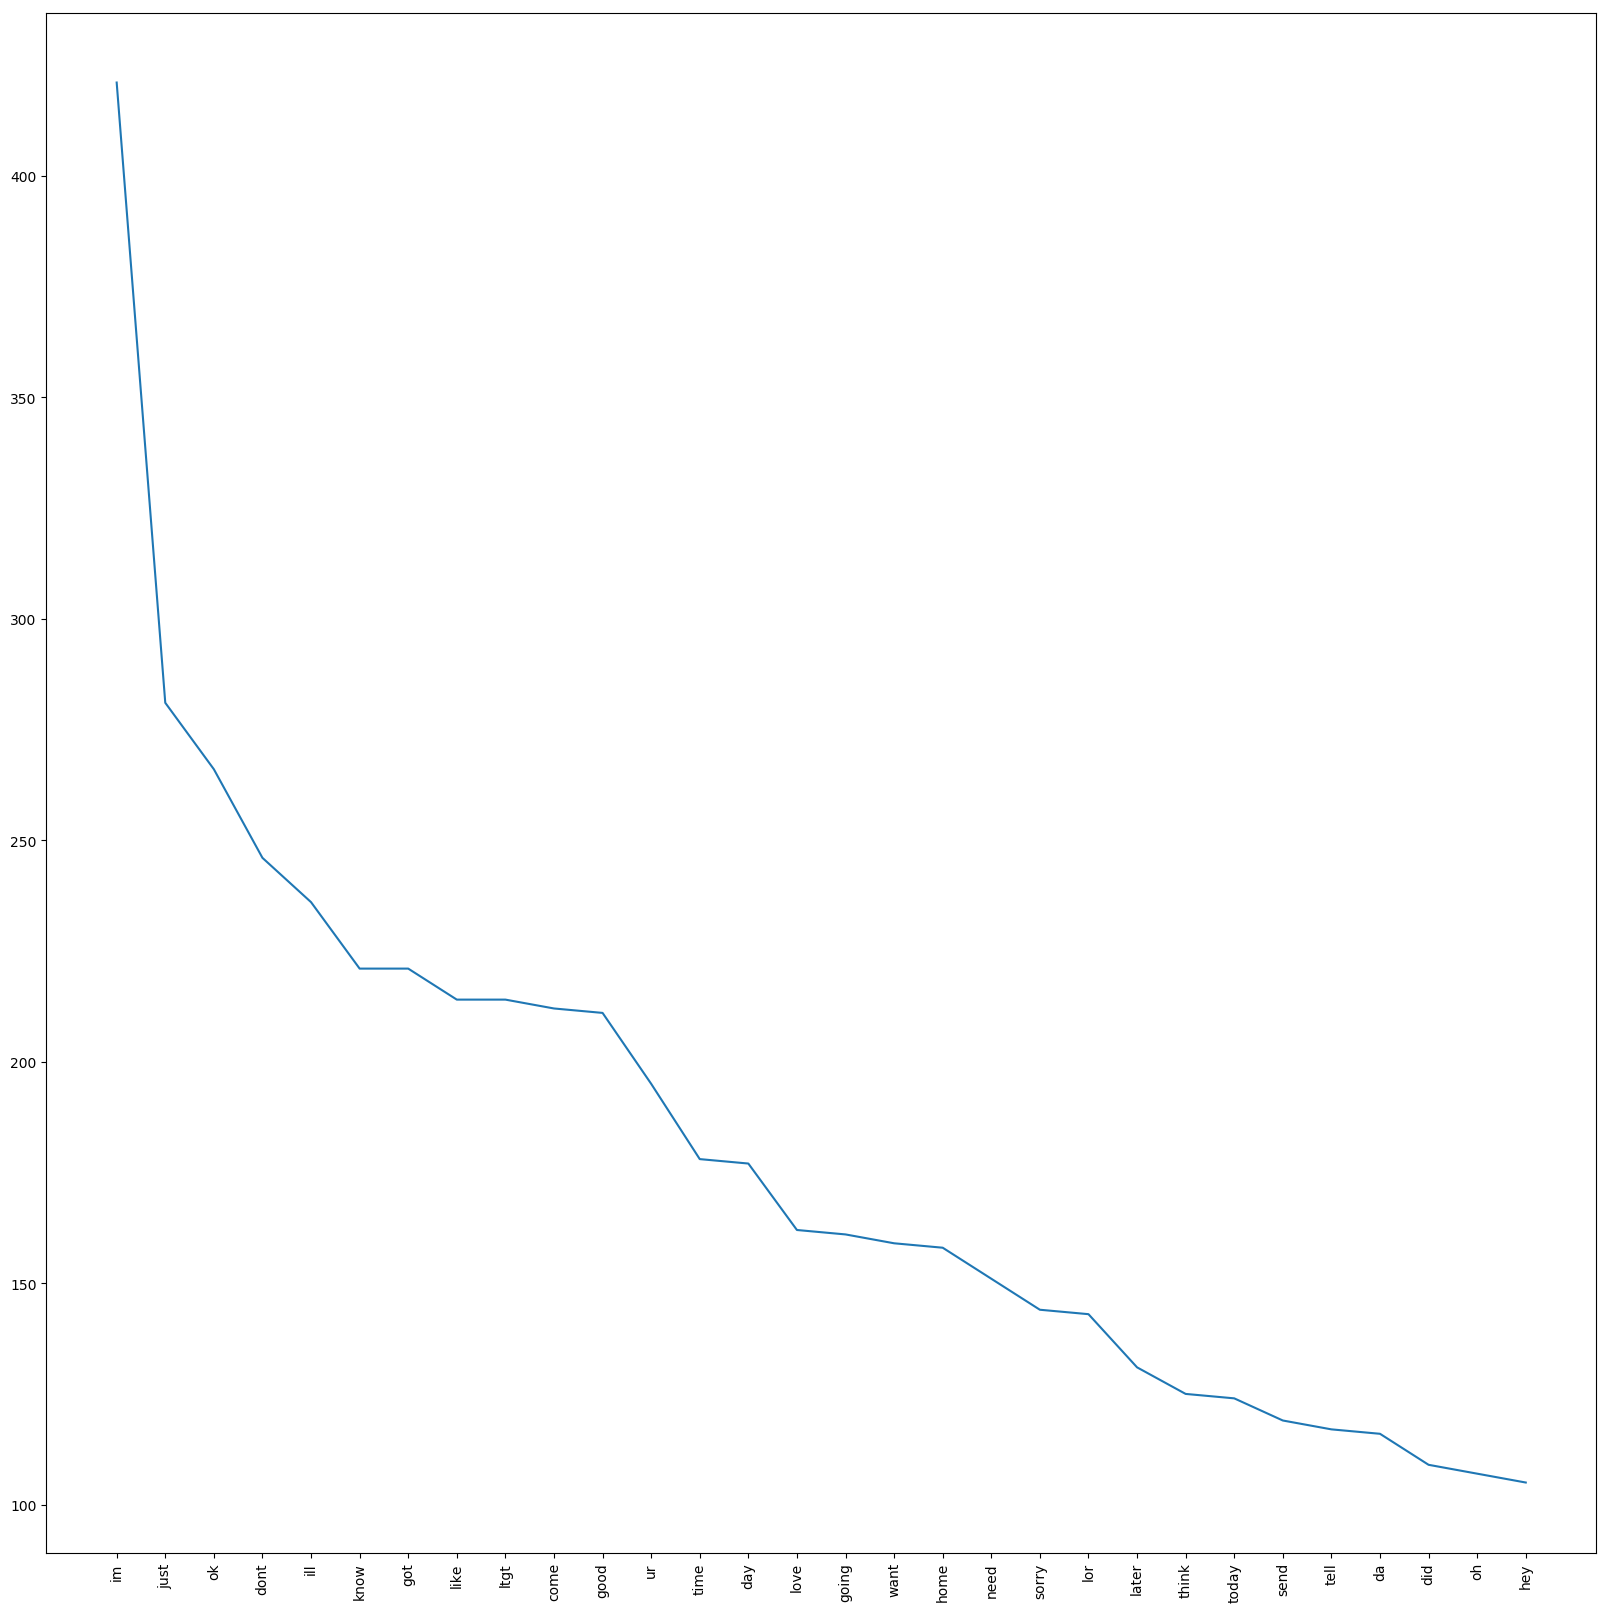

In [74]:
hd_index = pd.RangeIndex(start=0, stop=len(ham_dtt_dict))
ham_dtt = pd.DataFrame(list(ham_dtt_dict.items()), index= hd_index, columns = ['Word', 'Count'])

ham_dtt.sort_values(by=['Count'], ascending=False)

ham_sums = hd.select_dtypes(pd.np.number).sum().rename('total')
hd1 = hd.append(ham_sums)
hd2 = hd1.transpose()
hd3 = pd.DataFrame(hd2)
hd4 = hd3.loc[hd3['total'] > 100]
hd5 = hd4.sort_values(by = 'total', ascending=False)
hd6 = hd5['total']

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 20
plt.plot(hd6.index, hd6)
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114],
 <a list of 115 Text xticklabel objects>)

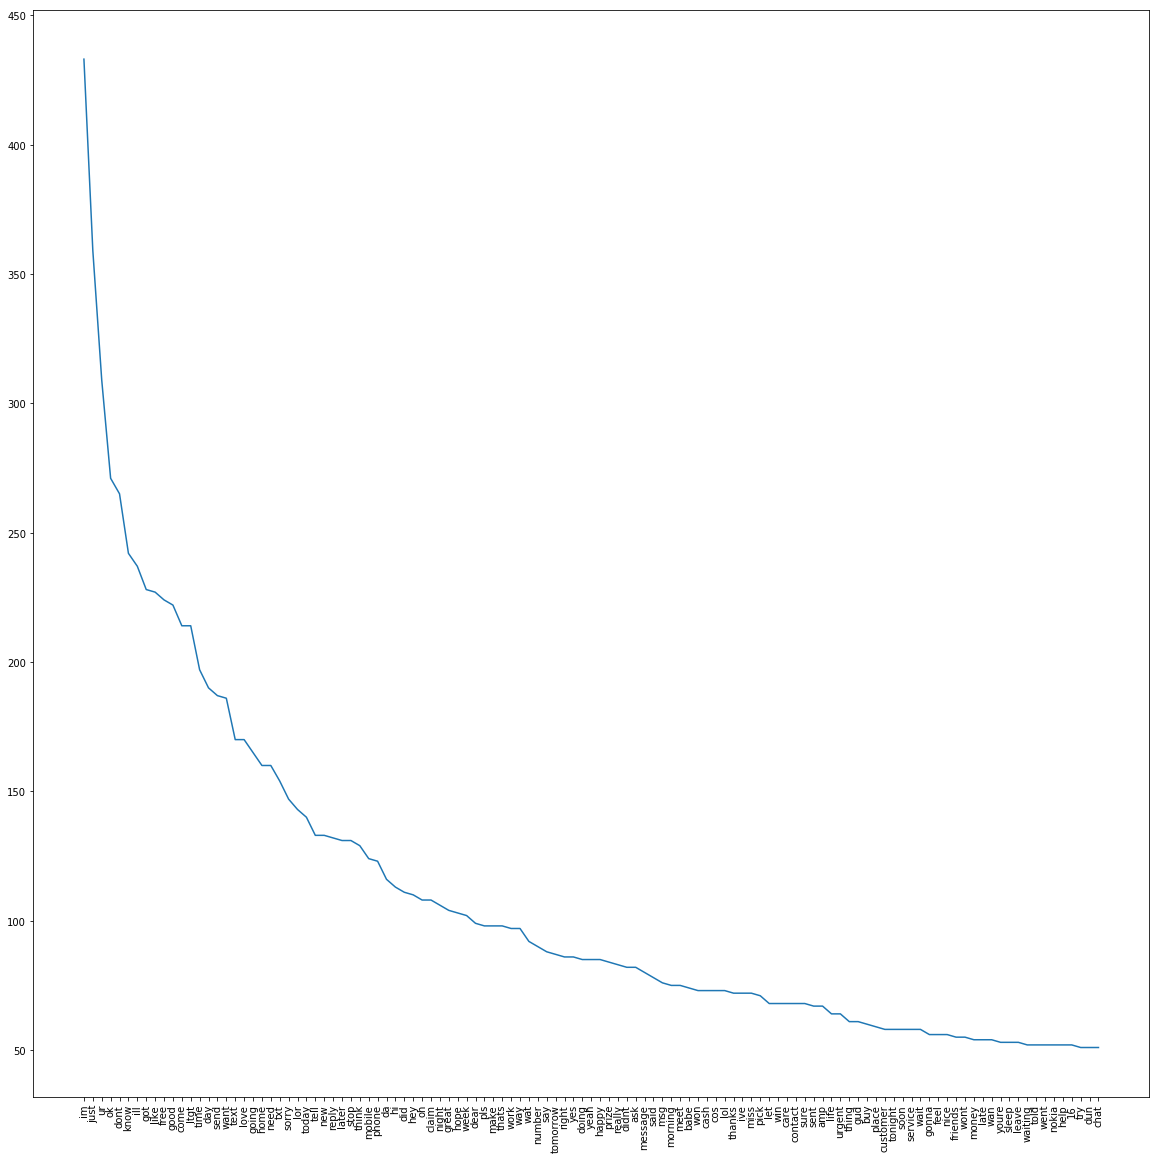

In [13]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 20
plt.plot(h.index, h)
plt.xticks(rotation=90)

In [74]:
# count_vect_sing_word is a CountVectorizer
def _indicesForSentence(input_str, tokenizer = tokenizer_word, count_vect = count_vect_sing_word):
    input_str = list(filter(lambda x: x in count_vect.vocabulary_, tokenizer(input_str)))
    return torch.tensor([[word_to_ix[word]] for word in input_str], dtype=torch.long)

def sentenceToNumpyInstance(input_str, embedder):
    embeddings = embedder(_indicesForSentence(input_str))
    if embeddings.shape == torch.Size([0]):
        return np.zeros(EMBEDDING_SIZE)
    else:
        return torch.Tensor.numpy(embeddings.detach())
    
def word2vec_transform(data, embeddings, field = 'Lower Case Text'):
    return np.array(data[field].apply(sentenceToNumpyInstance, embedder=embeddings).values.tolist())

first_vec = word2vec_transform(data, word_embeddings)[0][0][0]
word2vec_transform(data, word_embeddings).shape

import umap
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
%matplotlib inline

digits = load_digits()
digits.data[0]
embedding = umap.UMAP().fit_transform(digits.data)
first_vec = first_vec.reshape(-1,1)
embedding1 = umap.UMAP().fit_transform(first_vec)

(5572,)